In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, Flatten, concatenate
from keras import Model

### Create layer architecture as specified in diagram

#### 6 Inputs:
- From Visible Image
    - Laplacian Variance (Scalar)
    - FFT Power Spectrum (1D Array)
- From Infrared Image
    - Laplacian Variance (Scalar)
    - FFT Power Spectrum (1D Array)
- From Lidar Point Cloud
    - Pings vs. Depth Distribution (1D Array)
    - Depth Map (2D Matrix)

### Visible Inputs

In [2]:
powerSpectrumLength = 512 # Change this later

visible_lapVariance = Input(shape=(1,),  # Scalar
                                  name="Visible_Laplacian_Variance",
                                  dtype="float32")

visible_powerSpectrum = Input(shape=(powerSpectrumLength,), # 1D array
                                    name="Visible_Power_Spectrum",
                                    dtype="float32")

### Infrared Inputs

In [3]:
infrared_lapVariance = Input(shape=(1,),  # Scalar
                                  name="Infrared_Laplacian_Variance",
                                  dtype="float32")

infrared_powerSpectrum = Input(shape=(powerSpectrumLength,), # 1D array
                                    name="Infrared_Power_Spectrum",
                                    dtype="float32")

### Lidar Inputs

In [4]:
distributionLength = 100 # Change later
depthMapDimensions = (20, 20) # Change later

lidar_pingDistribution = Input(shape=(distributionLength,),  # 1D array
                                  name="Lidar_Ping_Distribution",
                                  dtype="float32")

lidar_depthMap = Input(shape=depthMapDimensions, # 2D array
                             name="Lidar_Depth_Map",
                             dtype="float32")

### Combine imagery inputs into "intermediary" layers

Currently, the visible, infrared, and lidar data is "fed" through 2 inputs each for 6 total inputs. The next layer will concatenate the data into 1 input per camera, for a total of 3 different  Finally, there will be another layer to concatenate the these 3 layers into just 1 layer.

In [5]:
visibleCombined = concatenate([visible_lapVariance,
                                      visible_powerSpectrum],
                                      name="Combined_Visible")

infraredCombined = concatenate([infrared_lapVariance,
                                       infrared_powerSpectrum],
                                       name="Combined_Infrared")

lidar_depthMapFlat = Flatten()(lidar_depthMap)

lidarCombined = concatenate([lidar_pingDistribution,
                                    lidar_depthMapFlat],
                                    name="Combined_Lidar")

allImageryCombined = concatenate([visibleCombined,
                                         infraredCombined,
                                         lidarCombined],
                                         name="Comprehensive_Inputs")

### Dense Layers

Now that we have the imagery inputs in into just 1 layer (in which the input values have not been modified), we can now feed the values into dense layers for the genuine "learning" part of machine learning.

How many layers are optimal for neural network training? There is no good, analytical way to determine this, but we will choose use 3 for our model. The number of neurons will decrease for the layers closer to the output, as the weights in the third layer should have more refinement and than the first layer.

We will use the relu (rectified linear unit) activiation function, as this is the most basic activiation function and does not suffer from the vanishing gradient problem (cite this too).

Future work could run a parameter study with the number of layers, the number of neurons within each layer, and the activiation function to determine the optimum configuration.

https://www.v7labs.com/blog/neural-networks-activation-functions#h5


In [6]:
neuronsInLayers = [64, 32, 16]  # This are arbitrarily-picked values

firstDense = Dense(units=neuronsInLayers[0],
                   activation="relu",
                   name="First_Dense_Layer")(allImageryCombined)

secondDense = Dense(units=neuronsInLayers[1],
                   activation="relu",
                   name="Second_Dense_Layer")(firstDense)

thirdDense = Dense(units=neuronsInLayers[2],
                   activation="relu",
                   name="Third_Dense_Layer")(secondDense)

### Output Layer

Our neural network will have two outputs (neurons): the ML-derived estimate for meteorological optical range (MOR) and liquid water content (LWC) of the environment that was captured with the visible, infrared, and lidar cameras.

We will use the Relu activation function again (instead of the linear activation function), as both MOR and LWC cannot be negative. In other words, an estimate of 0 (lower bound of Relu) is better than any negative estimate (lower bound of linear).

https://towardsdatascience.com/deep-learning-which-loss-and-activation-functions-should-i-use-ac02f1c56aa8

In [7]:
estimates = Dense(2,
                  activation="relu",
                  name="MOR_and_LWC_estimates")(thirdDense)

### Putting everything together...

In [8]:
neuralNetwork = Model(
                      inputs=[visible_lapVariance,
                              visible_powerSpectrum,
                              infrared_lapVariance,
                              infrared_powerSpectrum,
                              lidar_pingDistribution,
                              lidar_depthMap],
                      outputs=estimates
)

### Visualize Path of Data Through Neural Network

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Lidar_Depth_Map (InputLayer)   [(None, 20, 20)]     0           []                               
                                                                                                  
 Visible_Laplacian_Variance (In  [(None, 1)]         0           []                               
 putLayer)                                                                                        
                                                                                                  
 Visible_Power_Spectrum (InputL  [(None, 512)]       0           []                               
 ayer)                                                                                            
                                                                                              

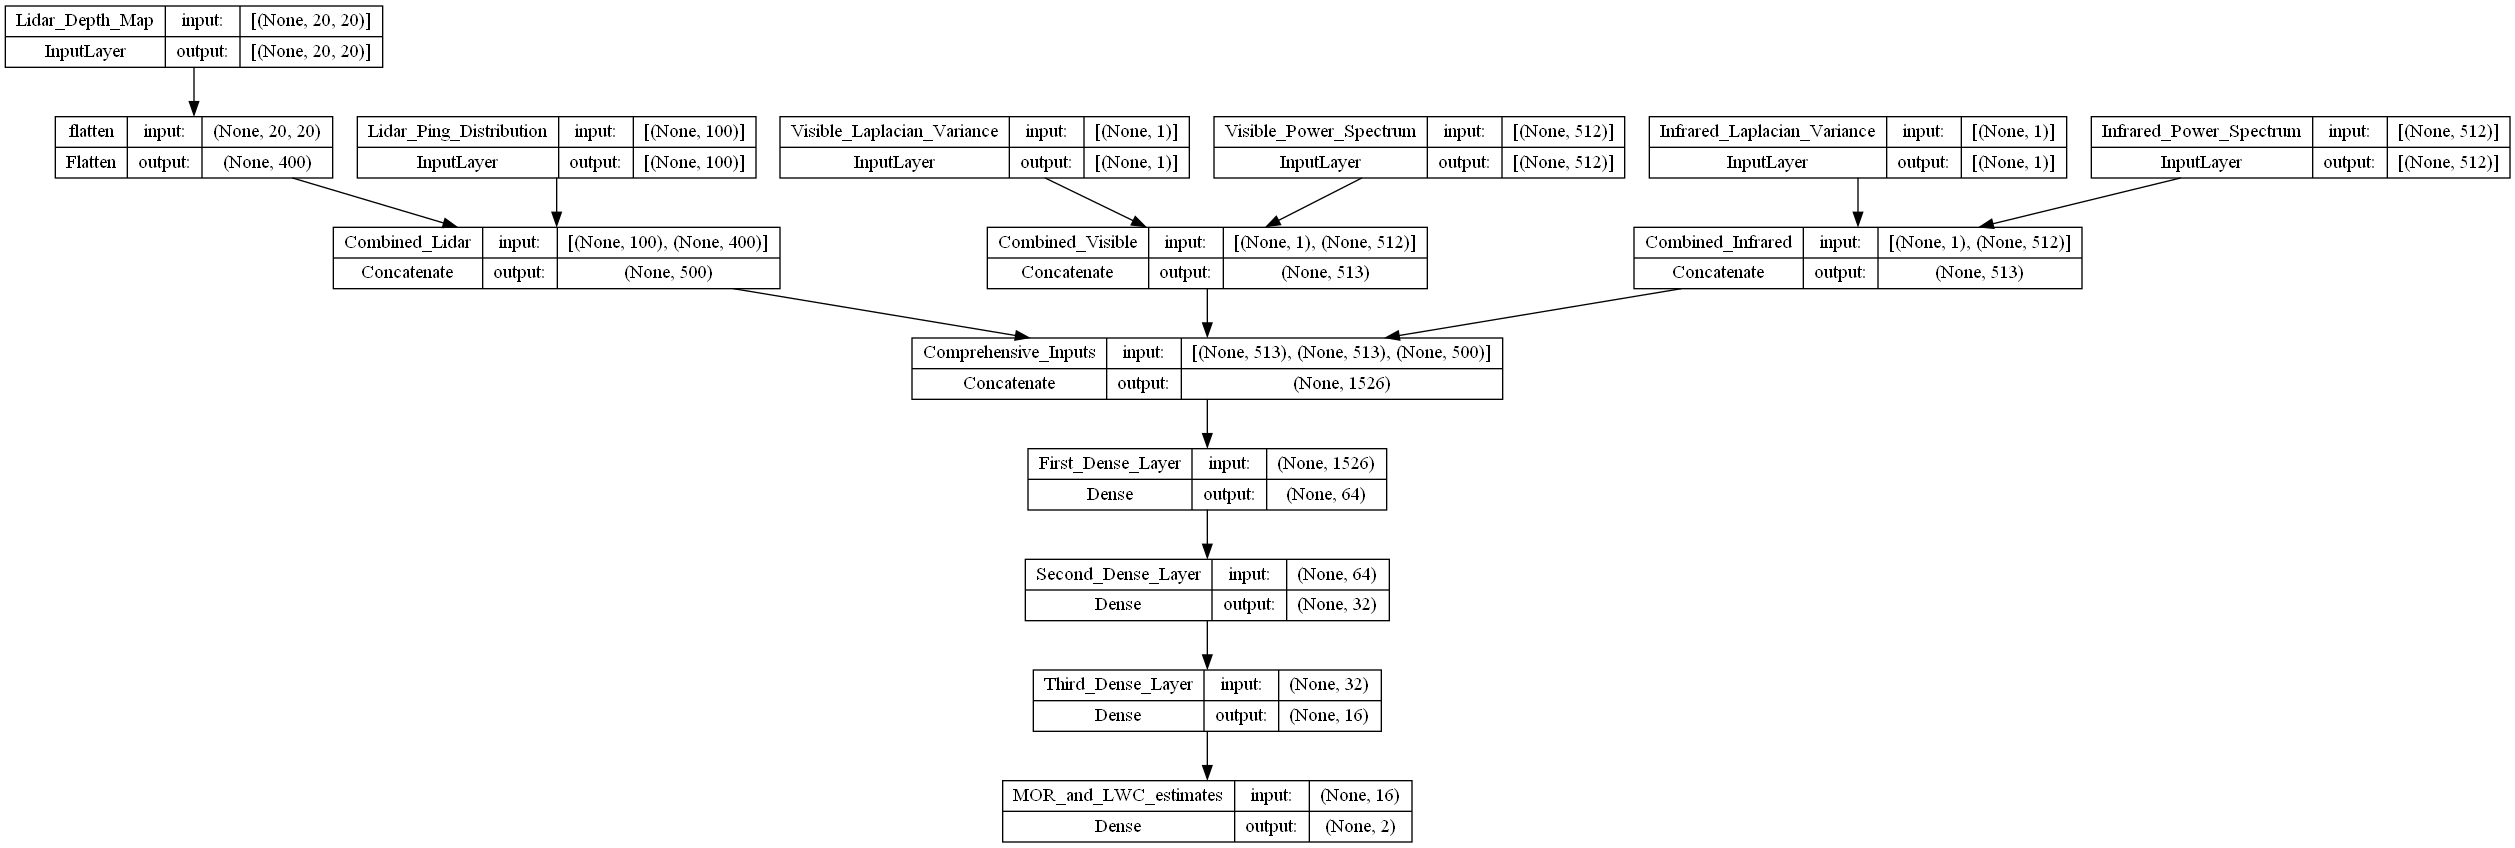

In [11]:
neuralNetwork.summary()
keras.utils.plot_model(neuralNetwork, show_shapes=True)